In [74]:
import csv
import time
import pandas as pd
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [95]:
# Setup driver(chrome+chromedriver)dynamically, API-functionality
service = Service(ChromeDriverManager().install())
options = Options()
options.binary_location = '/Applications/Google Chrome.app/Contents/MacOS/Google Chrome'
driver = webdriver.Chrome(service=service, options=options)

# Open the webpage
url = "https://cloud.withgoogle.com/next/25/speakers"
driver.get(url)

# Wait for page to load
WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'body')))
# Give the page a moment to fully render
time.sleep(3)  

all_speakers = []
current_page = 1
# there are 64 pages
max_pages = 64  

"""
# find next page debugging code
pagination_items = driver.find_elements(By.XPATH, "//a[contains(@class, 'pagination-list-item-link')]")
print("==== Detected Pagination Buttons ====")
for item in pagination_items:
    #打印HTML结构，看看有没有"Next"按钮
    print(item.get_attribute('outerHTML'))  
"""


while current_page <= max_pages:
    print(f"\nProcessing page {current_page} of {max_pages}")
    
    # Find all speaker cards on the current page
    speaker_cards = driver.find_elements(By.CSS_SELECTOR, '.speaker-card')

    if current_page == 1:
        # Page 1: scrape all speakers (including featured)
        speaker_cards = driver.find_elements(By.CSS_SELECTOR, '.speaker-card')
    else:
        # Pages 2-64: Skip featured speakers by selecting only regular speakers
        all_speaker_cards = driver.find_elements(By.CSS_SELECTOR, '.speaker-card')
        speaker_cards = all_speaker_cards[31:]
        #speaker_cards = driver.find_elements(By.CSS_SELECTOR, '.speaker-card:not(.featured-speaker)')
        #speaker_cards = driver.find_elements(By.CSS_SELECTOR, "//div[contains(@class, 'speaker-card') and not(ancestor::div[@id='featured-speakers'])]")
        #speaker_cards = driver.find_elements(By.CSS_SELECTOR, "div.speaker-card:not(#featured-speakers div.speaker-card)")
        
    print(f"Found {len(speaker_cards)} speaker cards on this page")
    
    # Process each speaker card on the current page
    for i, card in enumerate(speaker_cards):
        try:
            # Scroll to card
            driver.execute_script("arguments[0].scrollIntoView(true);", card)
            time.sleep(1)
            
            # Try to remove or deal with the banner that's intercepting clicks
            try:
                banner = driver.find_element(By.CSS_SELECTOR, '.banner')
                driver.execute_script("arguments[0].style.display = 'none';", banner)
            except:
                pass
            
            # Use JavaScript to click the card
            driver.execute_script("arguments[0].click();", card)
            # Wait for modal to appear
            time.sleep(2)  
            
            # Extract data from modal
            try:
                name = driver.find_element(By.CSS_SELECTOR, '.info-full-name').text
                job = driver.find_element(By.CSS_SELECTOR, '.info-job-title').text
                company = driver.find_element(By.CSS_SELECTOR, '.info-company').text
                
                #print(f"Speaker {i+1}: {name}, {job}, {company}")
                all_speakers.append((name, job, company))
                
                # Close modal
                try:
                    close_btn = driver.find_element(By.CSS_SELECTOR, '.close-button')
                    driver.execute_script("arguments[0].click();", close_btn)
                except:
                    ActionChains(driver).send_keys(Keys.ESCAPE).perform()
                    
                time.sleep(1)  # Wait for modal to close
                
            except Exception as e:
                print(f"Error extracting speaker data: {e}")
        
        except Exception as e:
            print(f"Error processing card {i+1}: {e}")
    
    # Move to the next page if not on the last page
    if current_page < max_pages:
        try:
            try:
                #next_button = driver.find_element(By.XPATH, "//a[contains(@class, 'pagination-list-item-link-arrow')]")
                next_button = driver.find_element(By.XPATH, "//a[@aria-label='Next page']")
                if next_button:
                    print(f"Found next button: {next_button.get_attribute('outerHTML')}")
            except:
                next_button = None
                
            # Click the next button using JavaScript
            if next_button:
                driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
                time.sleep(1)
                driver.execute_script("arguments[0].click();", next_button)
                # Wait for the new page to load
                time.sleep(3)  
                current_page += 1
            else:
                print("Could not find the next page button. Stopping pagination.")
                break
                
        except Exception as e:
            print(f"Error navigating to next page: {e}")
            break
    else:
        break


# Print results
print(f"\nTotal speakers found across all pages: {len(all_speakers)}")


Processing page 1 of 64
Found 56 speaker cards on this page
Found next button: <a data-v-4d237c49="" href="#" rel="noopener" aria-label="Next page" data-automation="paginationNext" class="pagination-list-item-link pagination-list-item-link_arrow"><i data-v-4d237c49="" class="material-icons notranslate">arrow_forward_ios</i></a>

Processing page 2 of 64
Found 25 speaker cards on this page
Found next button: <a data-v-4d237c49="" href="#" rel="noopener" aria-label="Next page" data-automation="paginationNext" class="pagination-list-item-link pagination-list-item-link_arrow"><i data-v-4d237c49="" class="material-icons notranslate">arrow_forward_ios</i></a>

Processing page 3 of 64
Found 25 speaker cards on this page
Found next button: <a data-v-4d237c49="" href="#" rel="noopener" aria-label="Next page" data-automation="paginationNext" class="pagination-list-item-link pagination-list-item-link_arrow"><i data-v-4d237c49="" class="material-icons notranslate">arrow_forward_ios</i></a>

Proces

In [65]:
def is_empty_row(row):
    return all(not elem for elem in row if elem is not None)

all_valid_speakers = [speaker for speaker in all_speakers if not is_empty_row(speaker)]

csv_filename = "all_valid_speakers_data.csv"
with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Name", "Job", "Company"])  # Write header
    writer.writerows(all_valid_speakers)  # Write data rows
print(f"\n✅ Data successfully saved to {csv_filename} with {len(all_valid_speakers)} records.") 


✅ Data successfully saved to all_valid_speakers_data.csv with 1570 records.


In [67]:
# Close driver
driver.quit()

In [70]:
all_valid_speakers = pd.read_csv("all_valid_speakers_data.csv")

In [71]:
print(all_valid_speakers)

                     Name                                        Job  \
0           Thomas Kurian                                        CEO   
1          Yulie Kwon Kim            VP of Product, Google Workspace   
2             Matt Renner                  President, Global Revenue   
3           Jeanine Banks                       VP & GM, Developer X   
4            Sandra Joyce             VP, Google Threat Intelligence   
...                   ...                                        ...   
1565          Michael Zuo              Head of Professional Services   
1566             John Zur  Senior Director of Information Technology   
1567  Stas Zvinyatskovsky               Head of Engineering Platform   
1568      Michal Zylinski                            Product Manager   
1569          Murat Özcan               Head of Data & ML Experience   

           Company  
0     Google Cloud  
1     Google Cloud  
2     Google Cloud  
3     Google Cloud  
4     Google Cloud  
...      

In [88]:
sorted_df = all_valid_speakers.sort_values("Name")
print(sorted_df)
# write sorted valid speakers to csv file
sorted_df.to_csv("all_valid_speakers_data(sorted).csv", index=False)

                  Name                                      Job  \
651     Aakashi Kapoor                          Product Manager   
169   Aakriti Bhargava                    VP – Engineering & AI   
266     Aamer Charania   Head of Applied Machine Learning (AML)   
152         Aaron Berg             VP of Digital Transformation   
1102     Aaron Purcell   Managing Director, Internal Innovation   
...                ...                                      ...   
49           Zack Akil             Developer Relations Engineer   
1085       Zenul Pomal  Executive Director - Data Core Platform   
47        Zohaib Ahmed                          Founder and CEO   
540        Zoltan Guth                                      CTO   
1553       Zoran Zaric                Cloud Principal Architect   

                     Company  
651             Google Cloud  
169                Revionics  
266                 Best Buy  
152                  Walmart  
1102                    KPMG  
...      

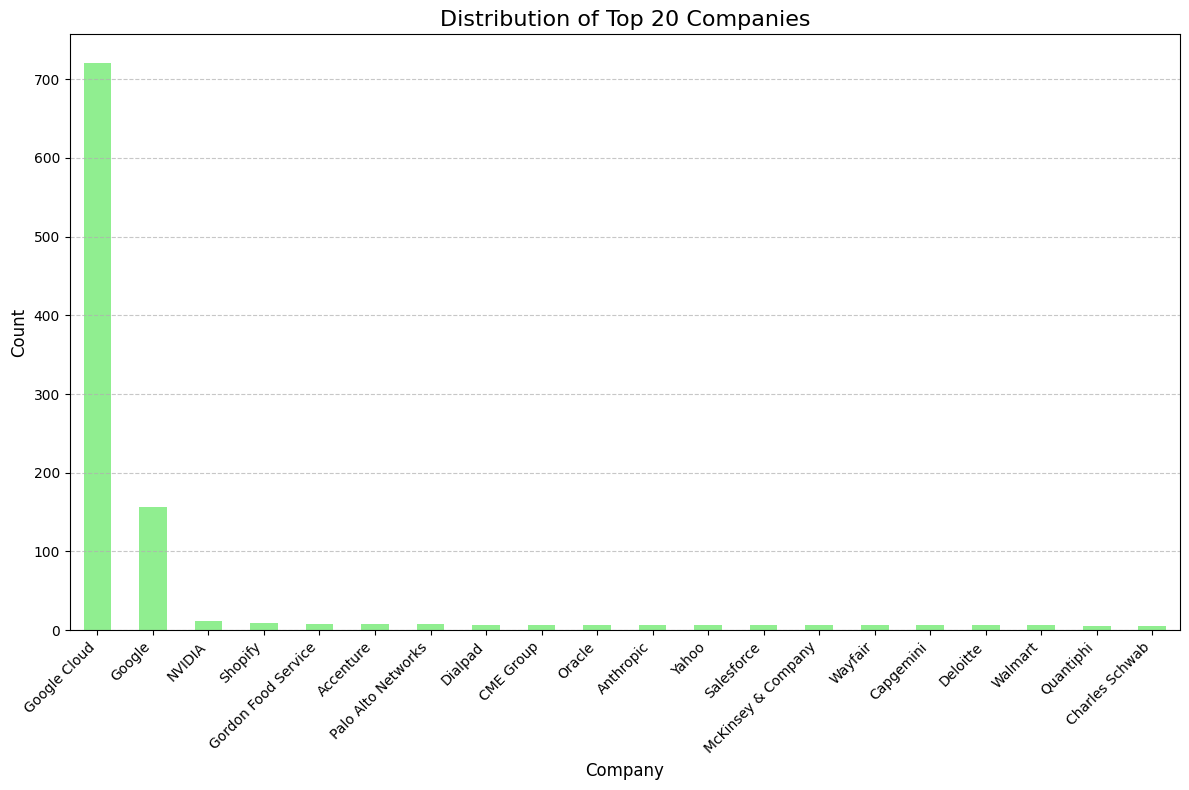

Total unique companies: 434
Most common company: Google Cloud (appears 721 times)

Top 10 Companies:
Company
Google Cloud           721
Google                 157
NVIDIA                  12
Shopify                  9
Gordon Food Service      8
Accenture                8
Palo Alto Networks       8
Dialpad                  7
CME Group                7
Oracle                   7
Name: count, dtype: int64


In [84]:
# Plot distribution of companies
plt.figure(figsize=(12, 8))

# Company distribution - top 20
company_counts = all_valid_speakers['Company'].value_counts().head(20)  # Getting top 20 companies
company_counts.plot(kind='bar', color='lightgreen')
plt.title('Distribution of Top 20 Companies', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('company_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Total unique companies: {all_valid_speakers['Company'].nunique()}")
print(f"Most common company: {all_valid_speakers['Company'].value_counts().index[0]} (appears {all_valid_speakers['Company'].value_counts().iloc[0]} times)")

print("\nTop 10 Companies:")
print(all_valid_speakers['Company'].value_counts().head(10))

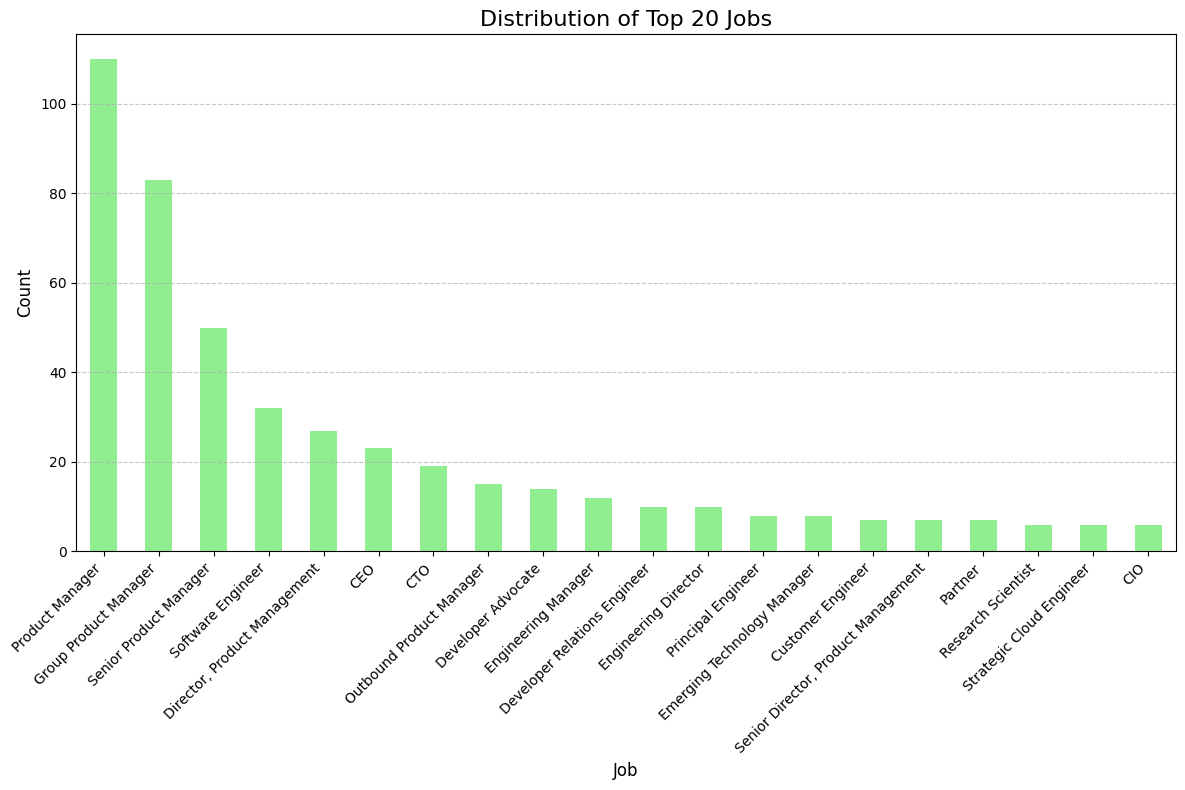

Total unique companies: 994
Most common company: Product Manager (appears 110 times)

Top 10 Jobs:
Job
Product Manager                 110
Group Product Manager            83
Senior Product Manager           50
Software Engineer                32
Director, Product Management     27
CEO                              23
CTO                              19
Outbound Product Manager         15
Developer Advocate               14
Engineering Manager              12
Name: count, dtype: int64


In [86]:
# Plot distribution of companies
plt.figure(figsize=(12, 8))

# Company distribution - top 20
company_counts = all_valid_speakers['Job'].value_counts().head(20)  # Getting top 20 companies
company_counts.plot(kind='bar', color='lightgreen')
plt.title('Distribution of Top 20 Jobs', fontsize=16)
plt.xlabel('Job', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('job_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Total unique companies: {all_valid_speakers['Job'].nunique()}")
print(f"Most common company: {all_valid_speakers['Job'].value_counts().index[0]} (appears {all_valid_speakers['Job'].value_counts().iloc[0]} times)")

print("\nTop 10 Jobs:")
print(all_valid_speakers['Job'].value_counts().head(10))